# Used Vehicles Price Prediction 

<big>Predict the price of the used vehicles based on kilometers driven and age of the car</big>

In [23]:
#import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import date

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

## Data Exploration

In [24]:
# importing dataset and exploring it
used_cars = pd.read_csv('./used_cars.csv')
used_cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57480 entries, 0 to 57479
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Unnamed: 0          57480 non-null  int64 
 1   price               57480 non-null  int64 
 2   manufacturing_year  57480 non-null  int64 
 3   model               57480 non-null  object
 4   km_driven           57480 non-null  object
 5   fuel_type           57452 non-null  object
 6   transmission_type   57480 non-null  object
 7   brand               57480 non-null  object
 8   city                57480 non-null  object
 9   bodytype            57480 non-null  object
 10  number_of_owners    57480 non-null  int64 
dtypes: int64(4), object(7)
memory usage: 4.8+ MB


In [25]:
used_cars.head()

,Unnamed: 0,price,manufacturing_year,model,km_driven,fuel_type,transmission_type,brand,city,bodytype,number_of_owners
0,0,840000,2024,Kia Sonet,"10,000",Petrol,Manual,Kia,Rajkot,SUV,1
1,1,998000,2023,Kia Seltos,"10,107",Petrol,Manual,Kia,Coimbatore,SUV,1
2,2,889000,2025,Citroen Basalt,"5,000",Petrol,Manual,Citroen,Kolkata,SUV,1
3,3,550000,2022,Renault Kiger,"14,464",Petrol,Manual,Renault,Durg,SUV,1
4,4,1350000,2024,Kia Carens,"10,000",Diesel,Manual,Kia,Ranga reddy,MUV,1


- Checked Dataset shape
- Verified missing values

## Data Cleaning

In [26]:
# converts the km_driven to number
used_cars['km_driven'] = used_cars['km_driven'].str.replace(',', '').str.strip().astype(int)

# calculates how old the car is 
current_year = date.today().year
years_old = current_year - used_cars['manufacturing_year']
used_cars['years_old'] = years_old

In [27]:
# selects the columns that is actually needed for the model
columns_to_select = ['price', 'years_old', 'km_driven']
cars = used_cars.loc[:, columns_to_select]
cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57480 entries, 0 to 57479
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   price      57480 non-null  int64
 1   years_old  57480 non-null  int64
 2   km_driven  57480 non-null  int64
dtypes: int64(3)
memory usage: 1.3 MB


In [28]:
cars.head()

,price,years_old,km_driven
0,840000,2,10000
1,998000,3,10107
2,889000,1,5000
3,550000,4,14464
4,1350000,2,10000


<big>This is looking much better for the prediction</big>

In [29]:
# exploring the data
cars.describe()

,price,years_old,km_driven
count,5.748000e+04,57480.000000,5.748000e+04
mean,9.960825e+05,8.113483,7.268827e+04
std,1.832278e+06,4.383471,7.362408e+04
min,1.500000e+04,1.000000,2.000000e+00
25%,3.400000e+05,5.000000,3.710000e+04
50%,5.500000e+05,8.000000,6.300000e+04
75%,9.889160e+05,11.000000,9.300000e+04
max,2.000000e+08,37.000000,3.750000e+06


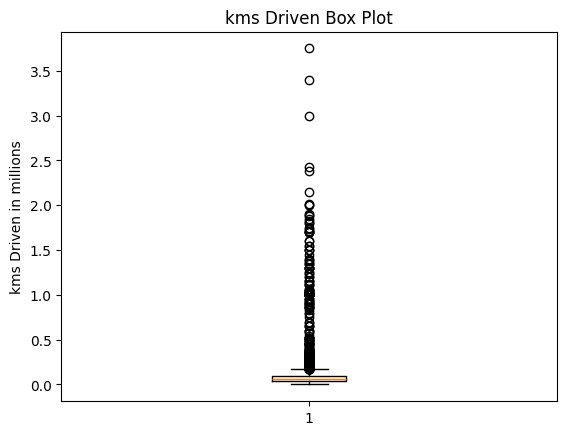

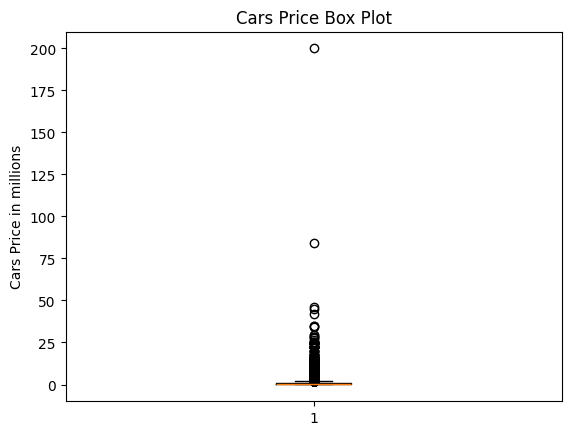

In [30]:
plt.boxplot(cars['km_driven'] / 1_000_000)
plt.title('kms Driven Box Plot')
plt.ylabel('kms Driven in millions')
plt.show()

plt.boxplot(cars['price'] / 1_000_000)
plt.title('Cars Price Box Plot')
plt.ylabel('Cars Price in millions')
plt.show()

<big>Its very hard to identify the outliers just by looking at the box plots</big>

In [31]:
# prints precentile from 99.1 to 99.9 to find outliers of km_driven
print("km_driven percentiles")
for i in range(1, 10):
    print(f"{99 + (i / 10)}%: {cars['km_driven'].quantile(0.99 + (i / 1_000))}")

km_driven percentiles
99.1%: 235300.0
99.2%: 243000.0
99.3%: 250000.0
99.4%: 250000.0
99.5%: 261210.0000000064
99.6%: 294781.9920000006
99.7%: 325000.0
99.8%: 500000.0
99.9%: 1042605.0000000396


<big>There is a large jump from 99.7 to 99.8 percentile so km_driven over 375000 km can be considered outlier</big>

In [32]:
# prints precentile from 81 to 99 to find outliers of the price
print("price percentiles")
for i in range(1, 20):
    print(f"{80 + i}%: {cars['price'].quantile(0.80 + (i / 100))}")

price percentiles
81%: 1200000.0
82%: 1250000.0
83%: 1300000.0
84%: 1350000.0
85%: 1400000.0
86%: 1475000.0
87%: 1543448.3100000184
88%: 1600000.0
89%: 1701556.2099999883
90%: 1845000.0
91%: 1975000.0
92%: 2175000.0
93%: 2475000.0
94%: 2800000.0
95%: 3450000.0
96%: 4050000.0
97%: 5000000.0
98%: 6100000.0
99%: 8300000.0


<big>There is a large jump from 95 to 96 percentile so prices above 4500000 can be considered outlier</big>

<big>Removing outliers</big>

In [33]:
# removes the identified outliers for the price and the km_driven
cars = cars[
    (cars['price'] < 4500000) &
    (cars['km_driven'] < 375000) &
    (cars['years_old'] < 30)
]
cars.describe()

,price,years_old,km_driven
count,5.524200e+04,55242.000000,55242.000000
mean,7.457723e+05,8.262662,71858.431157
std,6.747594e+05,4.340812,45494.812172
min,1.500000e+04,1.000000,2.000000
25%,3.250000e+05,5.000000,40000.000000
50%,5.500000e+05,8.000000,65000.000000
75%,9.000000e+05,11.000000,94000.000000
max,4.495000e+06,29.000000,373000.000000


<big>This is much better and 75 percentile is in line with the max value</big>

<big>Feature Scaling</big>

In [34]:
# does log transformation on price and km_driven
cars['price'] = np.log(cars['price'])
cars['km_driven'] = np.log(cars['km_driven'])

<big>Applied log transformation to make scale the price and km_driven comparable to years_old</big>

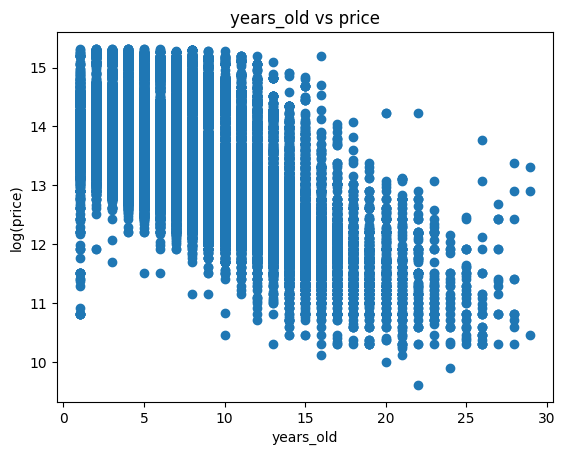

In [35]:
plt.scatter(cars['years_old'], cars['price'])

plt.xlabel('years_old')
plt.ylabel('log(price)')
plt.title('years_old vs price')

plt.show()

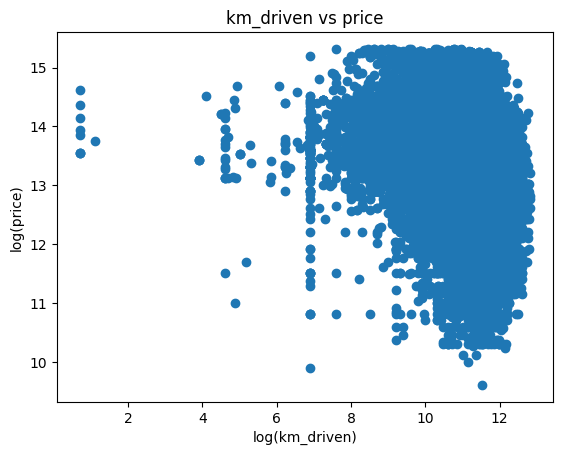

In [36]:
plt.scatter(cars['km_driven'], cars['price'])

plt.xlabel('log(km_driven)')
plt.ylabel('log(price)')
plt.title('km_driven vs price')

plt.show()

<big>Scatter plots after removing outliers and applying log transformation</big>

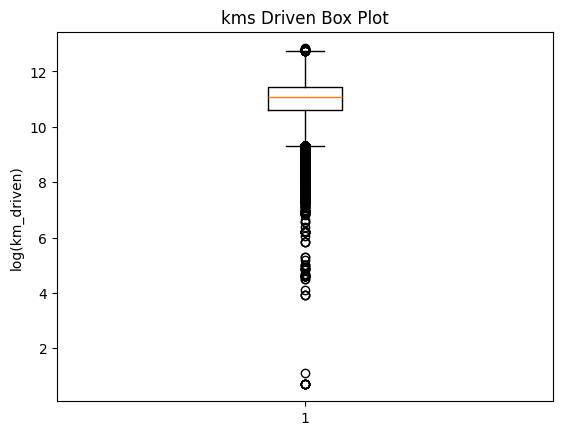

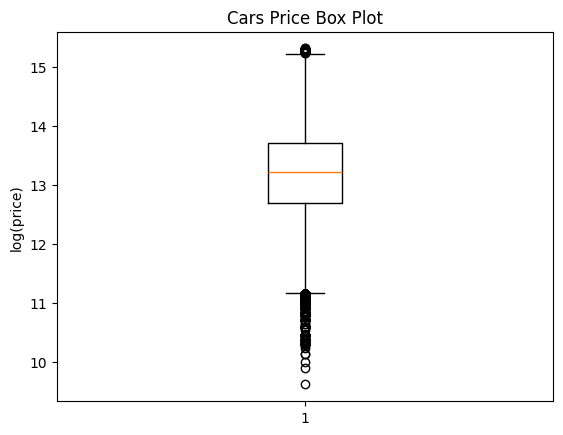

In [37]:
# box plots for price and km_driven
plt.boxplot(cars['km_driven'])
plt.title('kms Driven Box Plot')
plt.ylabel('log(km_driven)')
plt.show()

plt.boxplot(cars['price'])
plt.title('Cars Price Box Plot')
plt.ylabel('log(price)')
plt.show()

<big>Box Plots after featuring scaling</big>

In [38]:
from sklearn.model_selection import train_test_split
model = LinearRegression()

X = cars[['km_driven', 'years_old']]
Y = cars['price']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.8)

model.fit(X_train, Y_train)

prediction = model.predict(X_test)
sk_mse = mean_squared_error(Y_test, prediction)
print(np.sqrt(sk_mse))
print(model.score(X_train, Y_train))


0.5905770434431212
0.4627990539191781


<big>Model training with sk learn Linear Regression</big>

In [39]:
from linear_regression import LinearRegression1
from sklearn.metrics import r2_score

model1 = LinearRegression1(alpha=0.01, epochs=3000)
X1_train = X_train.to_numpy()
Y1_train = Y_train.to_numpy()

X1_test = X_test.to_numpy()

model1.fit(X1_train, Y1_train)

prediction = model1.predict(X1_test)
custom_mse = mean_squared_error(Y_test, prediction)
print(np.sqrt(custom_mse))
print(r2_score(Y_test, prediction))

0.9731708601672643
-0.44898978173228765


<big>Model training with self implemented Linear Regression Model</big>

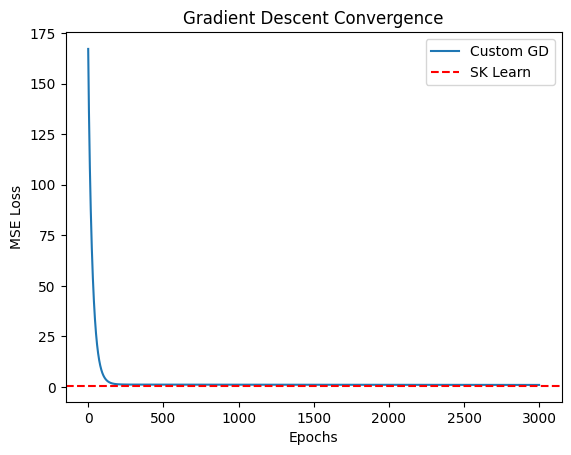

In [40]:
plt.figure()
plt.plot(model1.losses, label="Custom GD")
plt.axhline(sk_mse, color="red", linestyle="--", label="SK Learn")
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.title("Gradient Descent Convergence")
plt.legend()
plt.show()

<big>Plotting the Gradient Descent Convergence of self implemented model and MSE of the SKLearn Linear Regression Model.</big>

In [41]:
# metrics for boths models
print("SK Learn Model")
print(f"MSE: {np.sqrt(sk_mse)}")
print(f"R_squared score: {model.score(X_train, Y_train)}")

print("\nCustom Model")
print(f"MSE: {np.sqrt(custom_mse)}")
print(f"R_squared Score: {r2_score(Y_test, prediction)}")

SK Learn Model
MSE: 0.5905770434431212
R_squared score: 0.4627990539191781

Custom Model
MSE: 0.9731708601672643
R_squared Score: -0.44898978173228765


<big>Compares the metrics of both of the models</big>

# Conclusion

<big>This project helped me understand how Gradient Descent works and also how the Linear Regression works under the hood. This helped me understand how machine works internally.</big>